In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm

import fates_calibration_library.oaat_functions as oaat

In [2]:
param_dir = '/glade/work/afoster/FATES_calibration/parameter_files'
fates_param_list = os.path.join(param_dir, "param_list_sci.1.81.1_api.38.0.0.xls")
fates_param_key = os.path.join(param_dir, 'fates_oaat', 'fates_oaat_key.csv')
clm_param_list = os.path.join(param_dir, 'CLM5_Parameter_List.csv')

clm_param_dir = os.path.join(param_dir, 'clm_oaat')
fates_param_dir = os.path.join(param_dir, 'fates_oaat')
clm_tag = 'CLM6SPoaat'
fates_tag = 'FATES_OAAT_'

In [3]:
fates_key = pd.read_csv(fates_param_key, index_col=0)
fates_param_dat = oaat.get_fates_param_dat(fates_param_list, fates_key)
clm_param_dat = oaat.get_clm_param_dat(clm_param_list)

In [4]:
fates_default = xr.open_dataset(os.path.join(param_dir, 'fates_params_default_sci.1.81.1_api.38.0.0_crops_vai.nc'))
clm_default = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/paramdata/ctsm60_params.c241017.nc')
clm_pfts = [str(pft).replace("b'", "").replace("'", "").strip() for pft in clm_default.pftname.values]
fates_pfts = [str(pft).replace("b'", "").replace("'", "").strip() for pft in fates_default.fates_pftname.values]

In [31]:
clm_par = 'leafcn'
fates_par = 'fates_stoich_nitr'
clms = clm_param_dat.where(clm_param_dat.parameter_name == clm_par, drop=True).ensemble.values
fates = fates_param_dat.where(fates_param_dat.parameter_name == fates_par, drop=True).ensemble.values

In [32]:
clm_files = sorted([os.path.join(clm_param_dir, f"{clm_tag}{str(i).zfill(4)}.nc") for i in clms])
clm_ds = xr.open_mfdataset(clm_files, combine="nested", concat_dim="ensemble")

fates_files = sorted([os.path.join(fates_param_dir, f"{fates_tag}{str(i).zfill(3)}.nc") for i in fates])
fates_ds = xr.open_mfdataset(fates_files, combine="nested", concat_dim="ensemble")

In [33]:
if 'pft' in clm_ds[clm_par].dims:
    print('minimum values for clm:')
    vals = clm_ds[clm_par].isel(ensemble=0).values
    pft_inds = [4,1,3,5,6,7,9,11,10,11,11,12,13,14,15,16]
    for ind in pft_inds:
        print(clm_pfts[ind], ":", 1/vals[ind])
else:
    print('minimum values for clm:')
    print(clm_ds[clm_par].isel(ensemble=0).values)

minimum values for clm:
broadleaf_evergreen_tropical_tree : 0.06606721678635843
needleleaf_evergreen_temperate_tree : 0.018965208893241613
needleleaf_deciduous_boreal_tree : 0.055342857142857145
broadleaf_evergreen_temperate_tree : 0.048257142857142866
broadleaf_deciduous_tropical_tree : 0.060914285714285706
broadleaf_deciduous_temperate_tree : 0.060914285714285706
broadleaf_evergreen_shrub : 0.03922857142857144
broadleaf_deciduous_boreal_shrub : 0.05138247107552246
broadleaf_deciduous_temperate_shrub : 0.06142857142857143
broadleaf_deciduous_boreal_shrub : 0.05138247107552246
broadleaf_deciduous_boreal_shrub : 0.05138247107552246
c3_arctic_grass : 0.05348471647484373
c3_non-arctic_grass : 0.05097142857142856
c4_grass : 0.040400000000000005
c3_crop : 0.05714285714285714
c3_irrigated : 0.05714285714285714


In [10]:
print('minimum values for fates:')
vals = fates_ds[fates_par].isel(ensemble=0).values
for i in range(len(fates_pfts)):
    print(fates_pfts[i], ":", vals[:,i])

minimum values for fates:
broadleaf_evergreen_tropical_tree : [6.6e-03 4.8e-03 2.0e-09 9.4e-04]
needleleaf_evergreen_extratrop_tree : [5.8e-03 4.8e-03 2.0e-09 9.4e-04]
needleleaf_colddecid_extratrop_tree : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_evergreen_extratrop_tree : [6.6e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_hydrodecid_tropical_tree : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_colddecid_extratrop_tree : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_evergreen_extratrop_shrub : [6.6e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_hydrodecid_extratrop_shrub : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_colddecid_extratrop_shrub : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_evergreen_arctic_shrub : [6.6e-03 4.8e-03 2.0e-09 9.4e-04]
broadleaf_colddecid_arctic_shrub : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
arctic_c3_grass : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
cool_c3_grass : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
c4_grass : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
c3_crop : [8.0e-03 4.8e-03 2.0e-09 9.4e-04]
c

In [34]:
if 'pft' in clm_ds[clm_par].dims:
    print('maximum values for clm:')
    vals = clm_ds[clm_par].isel(ensemble=1).values
    pft_inds = [4,1,3,5,6,7,9,11,10,11,11,12,13,14,15,16]
    for ind in pft_inds:
        print(clm_pfts[ind], ":", 1/vals[ind])
else:
    print('maximum values for clm:')
    print(clm_ds[clm_par].isel(ensemble=1).values)

maximum values for clm:
broadleaf_evergreen_tropical_tree : 0.03557465519265454
needleleaf_evergreen_temperate_tree : 0.01021203555789933
needleleaf_deciduous_boreal_tree : 0.029800000000000004
broadleaf_evergreen_temperate_tree : 0.025984615384615387
broadleaf_deciduous_tropical_tree : 0.0328
broadleaf_deciduous_temperate_tree : 0.0328
broadleaf_evergreen_shrub : 0.021123076923076925
broadleaf_deciduous_boreal_shrub : 0.02766748442528133
broadleaf_deciduous_temperate_shrub : 0.03307692307692307
broadleaf_deciduous_boreal_shrub : 0.02766748442528133
broadleaf_deciduous_boreal_shrub : 0.02766748442528133
c3_arctic_grass : 0.028799462717223546
c3_non-arctic_grass : 0.027446153846153842
c4_grass : 0.021753846153846155
c3_crop : 0.03076923076923077
c3_irrigated : 0.03076923076923077


In [29]:
print('maximum values for fates:')
vals = fates_ds[fates_par].isel(ensemble=1).values
for i in range(len(fates_pfts)):
    print(fates_pfts[i], ":", vals[1,i])

maximum values for fates:
broadleaf_evergreen_tropical_tree : 0.0432
needleleaf_evergreen_extratrop_tree : 0.0432
needleleaf_colddecid_extratrop_tree : 0.0432
broadleaf_evergreen_extratrop_tree : 0.0432
broadleaf_hydrodecid_tropical_tree : 0.0432
broadleaf_colddecid_extratrop_tree : 0.0432
broadleaf_evergreen_extratrop_shrub : 0.0432
broadleaf_hydrodecid_extratrop_shrub : 0.0432
broadleaf_colddecid_extratrop_shrub : 0.0432
broadleaf_evergreen_arctic_shrub : 0.0432
broadleaf_colddecid_arctic_shrub : 0.0432
arctic_c3_grass : 0.0432
cool_c3_grass : 0.0432
c4_grass : 0.0432
c3_crop : 0.0432
c3_irrigated : 0.0432


In [13]:
fates_default[fates_par].values

array([[3.3e-02, 2.9e-02, 4.0e-02, 3.3e-02, 4.0e-02, 4.0e-02, 3.3e-02,
        4.0e-02, 4.0e-02, 3.3e-02, 4.0e-02, 4.0e-02, 4.0e-02, 4.0e-02,
        4.0e-02, 4.0e-02],
       [2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02,
        2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02, 2.4e-02,
        2.4e-02, 2.4e-02],
       [1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08,
        1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08, 1.0e-08,
        1.0e-08, 1.0e-08],
       [4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03,
        4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03, 4.7e-03,
        4.7e-03, 4.7e-03]])

In [27]:
if 'pft' in clm_ds[clm_par].dims:
    print('default values for clm:')
    vals = clm_default[clm_par].values
    pft_inds = [4,1,3,5,6,7,9,11,10,11,11,12,13,14,15,16]
    for ind in pft_inds:
    #for ind in range(0, len(clm_pfts)):
        print(clm_pfts[ind], ":", 1/vals[ind])
else:
    print('default values for clm:')
    print(clm_default[clm_par].values)

default values for clm:
broadleaf_evergreen_tropical_tree : 0.04624705175045091
needleleaf_evergreen_temperate_tree : 0.01327564622526913
needleleaf_deciduous_boreal_tree : 0.038740000000000004
broadleaf_evergreen_temperate_tree : 0.033780000000000004
broadleaf_deciduous_tropical_tree : 0.04264
broadleaf_deciduous_temperate_tree : 0.04264
broadleaf_evergreen_shrub : 0.027460000000000005
broadleaf_deciduous_boreal_shrub : 0.035967729752865725
broadleaf_deciduous_temperate_shrub : 0.043
broadleaf_deciduous_boreal_shrub : 0.035967729752865725
broadleaf_deciduous_boreal_shrub : 0.035967729752865725
c3_arctic_grass : 0.03743930153239061
c3_non-arctic_grass : 0.035679999999999996
c4_grass : 0.028280000000000003
c3_crop : 0.04
c3_irrigated : 0.04


In [337]:
out_dir = '/glade/work/afoster/FATES_calibration/parameter_files/clm_oaat'

In [351]:
parameter = 'ko25_coef'
clm_default[parameter]/1e-3

<xarray.DataArray 'ko25_coef' ()>
array(278.4)

In [353]:
new_param = clm_default.copy(deep=False)
#new_values = np.full(len(clm_default[parameter].values), v)
new_values = 395*1E-3
new_param[parameter] = new_values
new_param.to_netcdf(os.path.join(out_dir, f'CLM6SPoaat0{129}.nc'))

In [75]:
parameters = np.unique(clm_param_dat.parameter_name)
pfts = np.arange(0, 17)
ncdf_params = [i for i in clm_default.data_vars]

In [207]:
bad_params = []
for parameter in parameters:
    if parameter in ncdf_params and parameter not in ['ck', 'kmax', 'ndays_off',
                                                      'ndays_on', 'psi50']:
        dat = clm_param_dat.where(clm_param_dat.parameter_name == parameter, drop=True)
        
        ensembles = dat.ensemble.values
        
        clm_files = sorted([os.path.join(clm_param_dir, f"{clm_tag}{str(i).zfill(4)}.nc") for i in ensembles])
        clm_ds = xr.open_mfdataset(clm_files, combine="nested", concat_dim="ensemble")
        
        if 'pft' in clm_ds[parameter].dims:
            if len(clm_default[parameter].dims) == 1:
                param_values = clm_ds[parameter].values[:,1:17]
                default_vals = clm_default[parameter].values[1:17]
                mindiff = default_vals - param_values[0, :]
                maxdiff = param_values[1, :] - default_vals
                if any(mindiff) < 0.0 or any(maxdiff) < 0.0:
                    bad_params.append(parameter)
            else:
                bad_params.append(parameter)
        else:
            param_values = clm_ds[parameter].values
            default_vals = clm_default[parameter].values
            if len(param_values) == 2:
                mindiff = default_vals - param_values[0]
                maxdiff = param_values[1] - default_vals
                if mindiff < 0.0:
                    bad_params.append(parameter)
                if maxdiff < 0.0:
                    bad_params.append(parameter)
            else:
                bad_params.append(parameter)
params_to_check = np.unique(bad_params)

In [210]:
params_to_check = np.unique(bad_params)
params_to_check

array(['a_coef', 'a_exp', 'accum_factor', 'aq_sp_yield_min', 'bgc_cn_s1',
       'bgc_cn_s3', 'bgc_rf_s2s1', 'cp25_yr2000', 'cwd_flig',
       'decomp_depth_efolding', 'fnr', 'interception_fraction',
       'kc25_coef', 'ko25_coef', 'lai_dl', 'n_baseflow', 'rootprof_beta',
       'snw_rds_refrz', 'theta_ip', 'tpu25ratio', 'wind_snowcompact_fact',
       'xdrdt', 'zlnd'], dtype='<U21')

In [297]:
len(params_to_check)

23

In [327]:
parameter = 'ndays_on' #params_to_check[23]
dat = clm_param_dat.where(clm_param_dat.parameter_name == parameter, drop=True)
ensembles = dat.ensemble.values
clm_files = sorted([os.path.join(clm_param_dir, f"{clm_tag}{str(i).zfill(4)}.nc") for i in ensembles])
clm_ds = xr.open_mfdataset(clm_files, combine="nested", concat_dim="ensemble")
param_values = clm_ds[parameter].values
default_vals = clm_default[parameter].values

In [330]:
clm_ds[parameter]

<xarray.DataArray 'ndays_on' (ensemble: 2, pft: 79)>
dask.array<concatenate, shape=(2, 79), dtype=timedelta64[ns], chunksize=(1, 79), chunktype=numpy.ndarray>
Coordinates:
    pftname  (pft) |S40 dask.array<chunksize=(79,), meta=np.ndarray>
Dimensions without coordinates: ensemble, pft
Attributes:
    long_name:  Number of days to complete leaf onset

Text(0.5, 1.0, 'ndays_on')

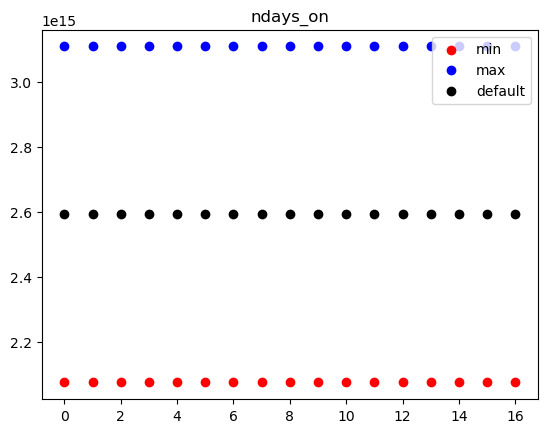

In [329]:
col_dict = {'min': 'red',
           'max': 'blue'}
seg=3
if 'pft' in clm_ds[parameter].dims:
    plt.scatter(pfts, param_values[0,0:17], color='red', label='min')
    plt.scatter(pfts, param_values[1,0:17], color='blue', label='max')
    plt.scatter(pfts, default_vals[0:17], color='black', label='default')
elif len(param_values) == 2:
    plt.scatter([0], param_values[0], color='red', label='min')
    plt.scatter([0], param_values[1], color='blue', label='max')
    plt.scatter([0], default_vals, color='black', label='default')
else:
    type = dat.type.values[0]
    plt.scatter([0], param_values, color=col_dict[type], label=type)
    plt.scatter([0], default_vals, color='black', label='default')
plt.legend()
plt.title(parameter)